# Library Data Preprocessing and Feature Engineering

**Team ID:** 19  
**Group:** 4  
**Date:** February 2026

---

## Overview

This notebook performs comprehensive analysis of library data through three phases:

1. **Data Cleaning**: Standardize columns, handle corrupted entries and missing values, remove duplicates
2. **Exploratory Data Analysis (EDA)**: Analyze borrowing patterns, reader behavior, and book popularity
3. **Feature Engineering**: Create structured features for clustering and association rule mining

---

## Data Sources

- **Borrowings.xlsx**: Transaction records of book borrowings
- **library_catalogue.xlsx**: Complete book catalogue with ISBN and copy information
- **LIBRARY_INVENTORY.xlsx**: Physical inventory with book status tracking

In [ ]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import os
import warnings

warnings.filterwarnings('ignore')

# Configure visualization settings
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)
%matplotlib inline

# Create output directories
os.makedirs('eda_figures', exist_ok=True)

print("✓ Environment configured successfully")

✓ Environment configured successfully


---

# Phase 1: Data Cleaning

This phase ensures data quality by:
- Standardizing column names to lowercase
- Replacing corrupted '?' entries with NaN
- Removing completely empty rows
- Handling missing values appropriately
- Converting date columns to datetime format
- Removing duplicates and standardizing text fields

## 1.1 Borrowings Data

The borrowings dataset contains transaction-level data with reader IDs, book titles, and loan dates.

In [ ]:
print("=" * 80)
print("CLEANING BORROWINGS FILE")
print("=" * 80)

# Load data
df_borrowings_raw = pd.read_excel('Borrowings.xlsx',
                                  sheet_name='DocEmpruntes',
                                  header=6)

print(f"\nInitial shape: {df_borrowings_raw.shape}")

# Standardize column names
df_borrowings_raw.columns = df_borrowings_raw.columns.str.lower()

# Check for corrupted '?' patterns
question_mark_counts = {}
for col in df_borrowings_raw.columns:
    if df_borrowings_raw[col].dtype == 'object':
        count = df_borrowings_raw[col].astype(str).str.strip().eq('?').sum()
        if count > 0:
            question_mark_counts[col] = count
            df_borrowings_raw.loc[df_borrowings_raw[col].astype(str).str.strip().eq('?'), col] = np.nan

if question_mark_counts:
    print(f"\nCleaned '?' patterns in: {list(question_mark_counts.keys())}")

# Remove empty rows
df_borrowings = df_borrowings_raw.dropna(how='all').copy()

# Analyze and handle missing values
missing_pct = (df_borrowings.isnull().sum() / len(df_borrowings) * 100).round(2)
cols_to_drop = missing_pct[missing_pct > 50].index.tolist()

if cols_to_drop:
    df_borrowings = df_borrowings.drop(columns=cols_to_drop)
    print(f"Dropped {len(cols_to_drop)} columns with >50% missing values: {cols_to_drop}")

# Convert date columns
date_columns = [col for col in df_borrowings.columns if 'date' in col.lower()]
for col in date_columns:
    df_borrowings[col] = pd.to_datetime(df_borrowings[col], errors='coerce')

# Remove rows with missing critical values
critical_cols = ['n° lecteur', 'titre']
for col in critical_cols:
    if col in df_borrowings.columns:
        df_borrowings = df_borrowings[df_borrowings[col].notna()].copy()

# Standardize book titles
if 'titre' in df_borrowings.columns:
    df_borrowings['titre'] = df_borrowings['titre'].str.lower().str.strip()
    print(f"\nUnique titles after standardization: {df_borrowings['titre'].nunique()}")

# Remove duplicates
initial_count = len(df_borrowings)
df_borrowings = df_borrowings.drop_duplicates()
print(f"Removed {initial_count - len(df_borrowings)} duplicate rows")

# Save cleaned data
df_borrowings.to_excel('cleaned_borrowings.xlsx', index=False)
print(f"\n✓ Final borrowings shape: {df_borrowings.shape}")
print("✓ Saved to: cleaned_borrowings.xlsx")

CLEANING BORROWINGS FILE

Initial shape: (422, 11)
Dropped 1 columns with >50% missing values: ['date réservation']

Unique titles after standardization: 133
Removed 0 duplicate rows

✓ Final borrowings shape: (422, 10)
✓ Saved to: cleaned_borrowings.xlsx


## 1.2 Catalogue Data

The catalogue contains book metadata including ISBN, title, author, and number of copies available.

In [ ]:
print("=" * 80)
print("CLEANING LIBRARY CATALOGUE FILE")
print("=" * 80)

# Load data
df_catalogue_raw = pd.read_excel('library_catalogue.xlsx',
                                 sheet_name='liste',
                                 header=2)

print(f"\nInitial shape: {df_catalogue_raw.shape}")

# Standardize column names
new_col_names = ['isbn_issn', 'titre', 'auteur', 'cote', 'nbr_exemplaires']
if len(df_catalogue_raw.columns) == len(new_col_names):
    df_catalogue_raw.columns = new_col_names
else:
    df_catalogue_raw.columns = df_catalogue_raw.columns.str.lower()

# Clean '?' patterns
for col in df_catalogue_raw.columns:
    if df_catalogue_raw[col].dtype == 'object':
        mask = df_catalogue_raw[col].astype(str).str.contains(r'\?{2,}', na=False)
        if mask.sum() > 0:
            df_catalogue_raw.loc[mask, col] = np.nan

# Remove empty rows
initial_count = len(df_catalogue_raw)
df_catalogue = df_catalogue_raw.dropna(how='all').copy()
print(f"Removed {initial_count - len(df_catalogue)} empty rows")

# Drop columns with too many missing values
missing_pct = (df_catalogue.isnull().sum() / len(df_catalogue) * 100)
cols_to_drop = missing_pct[missing_pct > 70].index.tolist()
if cols_to_drop:
    df_catalogue = df_catalogue.drop(columns=cols_to_drop)

# Standardize titles
if 'titre' in df_catalogue.columns:
    df_catalogue['titre'] = df_catalogue['titre'].str.lower().str.strip()
    print(f"\nUnique titles in catalogue: {df_catalogue['titre'].nunique()}")

# Clean number of copies
if 'nbr_exemplaires' in df_catalogue.columns:
    df_catalogue['nbr_exemplaires'] = pd.to_numeric(df_catalogue['nbr_exemplaires'], errors='coerce')
    missing_count = df_catalogue['nbr_exemplaires'].isnull().sum()
    if missing_count > 0:
        df_catalogue['nbr_exemplaires'].fillna(1, inplace=True)
        print(f"Filled {missing_count} missing copy counts with 1")

# Remove duplicate titles (keep max copies)
initial_count = len(df_catalogue)
df_catalogue = df_catalogue.sort_values('nbr_exemplaires', ascending=False).drop_duplicates(subset='titre', keep='first')
print(f"Removed {initial_count - len(df_catalogue)} duplicate titles")

# Save cleaned data
df_catalogue.to_excel('cleaned_catalogue.xlsx', index=False)
print(f"\n✓ Final catalogue shape: {df_catalogue.shape}")
print("✓ Saved to: cleaned_catalogue.xlsx")

CLEANING LIBRARY CATALOGUE FILE

Initial shape: (620, 5)
Removed 16 empty rows

Unique titles in catalogue: 581
Filled 88 missing copy counts with 1
Removed 22 duplicate titles

✓ Final catalogue shape: (582, 5)
✓ Saved to: cleaned_catalogue.xlsx


## 1.3 Inventory Data

The inventory tracks individual physical copies with their current status (on loan, available, etc.).

In [ ]:
print("=" * 80)
print("CLEANING LIBRARY INVENTORY FILE")
print("=" * 80)

# Load data
df_inventory_raw = pd.read_excel('LIBRARY_INVENTORY.xlsx',
                                 sheet_name='invClassique')

print(f"\nInitial shape: {df_inventory_raw.shape}")

# Standardize column names
df_inventory_raw.columns = df_inventory_raw.columns.str.lower()

# Clean '?' patterns
for col in df_inventory_raw.columns:
    if df_inventory_raw[col].dtype == 'object':
        mask = df_inventory_raw[col].astype(str).str.contains(r'\?{2,}', na=False)
        if mask.sum() > 0:
            df_inventory_raw.loc[mask, col] = np.nan

# Remove empty rows
initial_count = len(df_inventory_raw)
df_inventory = df_inventory_raw.dropna(how='all').copy()
print(f"Removed {initial_count - len(df_inventory)} empty rows")

# Drop columns with excessive missing values
missing_pct = (df_inventory.isnull().sum() / len(df_inventory) * 100)
cols_to_drop = missing_pct[missing_pct > 70].index.tolist()
if cols_to_drop:
    df_inventory = df_inventory.drop(columns=cols_to_drop)

# Standardize titles
if 'titre' in df_inventory.columns:
    df_inventory['titre'] = df_inventory['titre'].str.lower().str.strip()

# Handle status column
if 'statut' in df_inventory.columns:
    missing_status = df_inventory['statut'].isnull().sum()
    if missing_status > 0:
        most_frequent = df_inventory['statut'].mode()[0]
        df_inventory['statut'].fillna(most_frequent, inplace=True)
        print(f"Filled {missing_status} missing status values with '{most_frequent}'")

# Remove full duplicates
initial_count = len(df_inventory)
df_inventory = df_inventory.drop_duplicates()
print(f"Removed {initial_count - len(df_inventory)} duplicate rows")

# Save cleaned data
df_inventory.to_excel('cleaned_inventory.xlsx', index=False)
print(f"\n✓ Final inventory shape: {df_inventory.shape}")
print("✓ Saved to: cleaned_inventory.xlsx")

CLEANING LIBRARY INVENTORY FILE

Initial shape: (4255, 16)
Removed 0 empty rows
Filled 40 missing status values with 'Prêt externe'
Removed 0 duplicate rows

✓ Final inventory shape: (4255, 10)
✓ Saved to: cleaned_inventory.xlsx


## Phase 1 Summary

In [ ]:
print("\n" + "=" * 80)
print("PHASE 1 COMPLETE - DATA CLEANING SUMMARY")
print("=" * 80)

summary_data = [
    ['Borrowings', df_borrowings.shape, 'cleaned_borrowings.xlsx'],
    ['Catalogue', df_catalogue.shape, 'cleaned_catalogue.xlsx'],
    ['Inventory', df_inventory.shape, 'cleaned_inventory.xlsx']
]

for name, shape, filename in summary_data:
    print(f"\n{name}:")
    print(f"  Shape: {shape[0]} rows × {shape[1]} columns")
    print(f"  Saved: {filename}")

print("\n" + "=" * 80)


PHASE 1 COMPLETE - DATA CLEANING SUMMARY

Borrowings:
  Shape: 422 rows × 10 columns
  Saved: cleaned_borrowings.xlsx

Catalogue:
  Shape: 582 rows × 5 columns
  Saved: cleaned_catalogue.xlsx

Inventory:
  Shape: 4255 rows × 10 columns
  Saved: cleaned_inventory.xlsx



---

# Phase 2: Exploratory Data Analysis

In this phase, we explore the cleaned data to understand:
- Borrowing patterns and loan durations
- Book popularity and borrowing frequency
- Reader behavior and activity levels
- Temporal trends in library usage

In [ ]:
# Load cleaned datasets
df_borrowings = pd.read_excel('cleaned_borrowings.xlsx')
df_catalogue = pd.read_excel('cleaned_catalogue.xlsx')
df_inventory = pd.read_excel('cleaned_inventory.xlsx')

# Convert date columns
df_borrowings['date prêt'] = pd.to_datetime(df_borrowings['date prêt'])
df_borrowings['date retour'] = pd.to_datetime(df_borrowings['date retour'])

print("✓ Datasets loaded successfully")
print(f"  Borrowings: {df_borrowings.shape}")
print(f"  Catalogue: {df_catalogue.shape}")
print(f"  Inventory: {df_inventory.shape}")

✓ Datasets loaded successfully
  Borrowings: (422, 10)
  Catalogue: (582, 5)
  Inventory: (4255, 10)


## 2.1 Loan Duration Analysis

LOAN DURATION ANALYSIS

Total transactions: 422
Unique books: 133
Unique readers: 271
Date range: 2023-10-16 to 2024-10-31

Loan Duration Statistics:
count    422.000000
mean      16.270142
std       20.121909
min        7.000000
25%       15.000000
50%       15.000000
75%       15.000000
max      302.000000
Name: loan_duration_days, dtype: float64


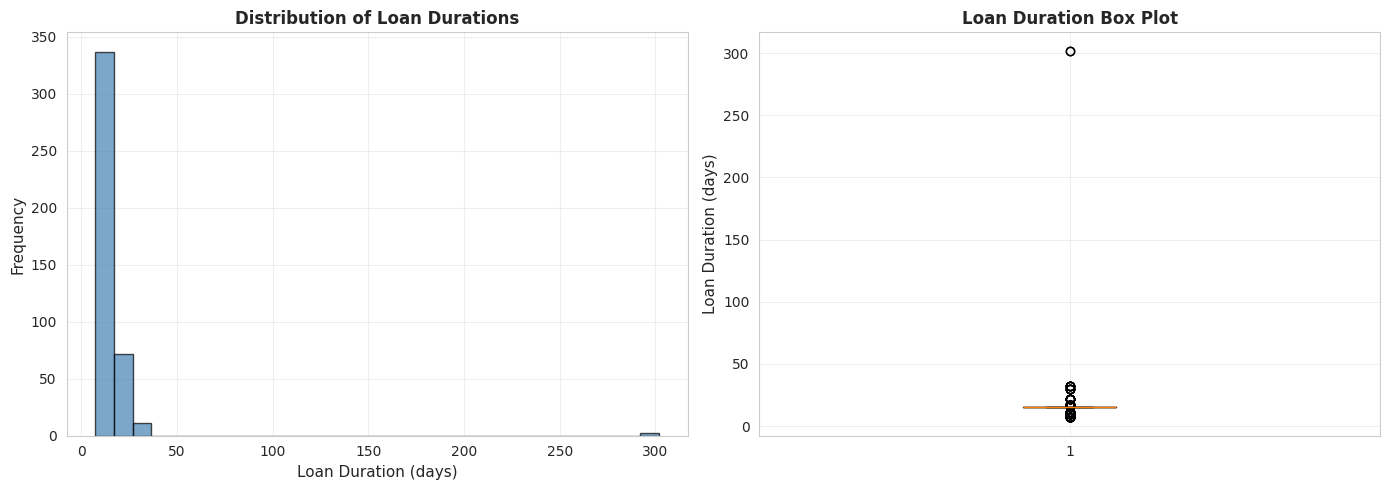


✓ Saved: eda_figures/01_loan_duration_distribution.png


In [ ]:
print("=" * 80)
print("LOAN DURATION ANALYSIS")
print("=" * 80)

# Basic statistics
print(f"\nTotal transactions: {len(df_borrowings)}")
print(f"Unique books: {df_borrowings['titre'].nunique()}")
print(f"Unique readers: {df_borrowings['n° lecteur'].nunique()}")
print(f"Date range: {df_borrowings['date prêt'].min().date()} to {df_borrowings['date prêt'].max().date()}")

# Calculate loan duration
df_borrowings['loan_duration_days'] = (df_borrowings['date retour'] - df_borrowings['date prêt']).dt.days

print("\nLoan Duration Statistics:")
print(df_borrowings['loan_duration_days'].describe())

# Visualize
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.hist(df_borrowings['loan_duration_days'].dropna(), bins=30,
         edgecolor='black', alpha=0.7, color='steelblue')
ax1.set_xlabel('Loan Duration (days)', fontsize=11)
ax1.set_ylabel('Frequency', fontsize=11)
ax1.set_title('Distribution of Loan Durations', fontsize=12, fontweight='bold')
ax1.grid(alpha=0.3)

ax2.boxplot(df_borrowings['loan_duration_days'].dropna())
ax2.set_ylabel('Loan Duration (days)', fontsize=11)
ax2.set_title('Loan Duration Box Plot', fontsize=12, fontweight='bold')
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('eda_figures/01_loan_duration_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Saved: eda_figures/01_loan_duration_distribution.png")

## 2.2 Book Popularity Analysis

BOOK POPULARITY ANALYSIS

Top 10 Most Borrowed Books:
titre
cours d'algèbre et exercices corrigés                                                                                       57
algebre 1 : rappels de cours et exercices avec solutions                                                                    55
fonctions de plusieurs variables relles : imites,continuite,differentiabilité et.... cours détaillé et exercices résolus    54
probabilites : rappels de cours et exercices corriges                                                                       18
tout sur r : ensemble des nombres reels structures algebrique et topologique                                                 9
mathématiques rappels et cours exercices résolus                                                                             9
fonctions réelles d'une variable réelle : dérivabilité, dérivées, développements limités                                     7
analyse 2 : rappels de cours et exercices avec solu

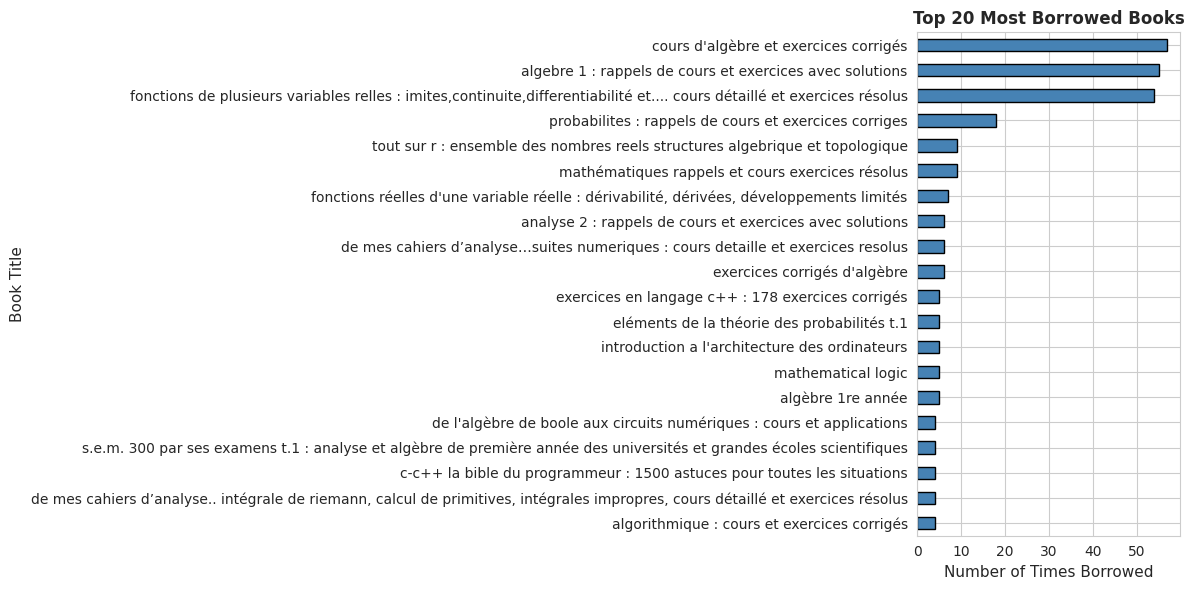


✓ Saved: eda_figures/02_top_borrowed_books.png


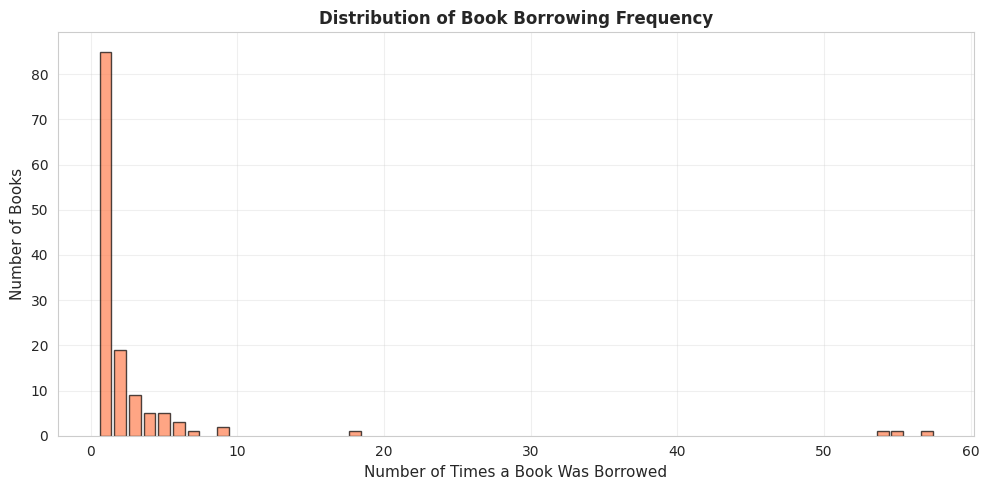

✓ Saved: eda_figures/03_borrowing_frequency_distribution.png

Borrowing Frequency Statistics:
  Books borrowed only once: 85
  Books borrowed 2-5 times: 38
  Books borrowed 6-10 times: 6
  Books borrowed >10 times: 4


In [ ]:
print("=" * 80)
print("BOOK POPULARITY ANALYSIS")
print("=" * 80)

# Calculate borrowing counts
book_borrowing_counts = df_borrowings['titre'].value_counts()

print(f"\nTop 10 Most Borrowed Books:")
print(book_borrowing_counts.head(10))

# Visualize top books
fig, ax = plt.subplots(figsize=(12, 6))
top_20_books = book_borrowing_counts.head(20)
top_20_books.plot(kind='barh', ax=ax, color='steelblue', edgecolor='black')
ax.set_xlabel('Number of Times Borrowed', fontsize=11)
ax.set_ylabel('Book Title', fontsize=11)
ax.set_title('Top 20 Most Borrowed Books', fontsize=12, fontweight='bold')
ax.invert_yaxis()
plt.tight_layout()
plt.savefig('eda_figures/02_top_borrowed_books.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Saved: eda_figures/02_top_borrowed_books.png")

# Borrowing frequency distribution
fig, ax = plt.subplots(figsize=(10, 5))
borrowing_freq_dist = book_borrowing_counts.value_counts().sort_index()
ax.bar(borrowing_freq_dist.index, borrowing_freq_dist.values,
       edgecolor='black', alpha=0.7, color='coral')
ax.set_xlabel('Number of Times a Book Was Borrowed', fontsize=11)
ax.set_ylabel('Number of Books', fontsize=11)
ax.set_title('Distribution of Book Borrowing Frequency', fontsize=12, fontweight='bold')
ax.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('eda_figures/03_borrowing_frequency_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Saved: eda_figures/03_borrowing_frequency_distribution.png")

# Frequency statistics
print(f"\nBorrowing Frequency Statistics:")
print(f"  Books borrowed only once: {(book_borrowing_counts == 1).sum()}")
print(f"  Books borrowed 2-5 times: {((book_borrowing_counts >= 2) & (book_borrowing_counts <= 5)).sum()}")
print(f"  Books borrowed 6-10 times: {((book_borrowing_counts >= 6) & (book_borrowing_counts <= 10)).sum()}")
print(f"  Books borrowed >10 times: {(book_borrowing_counts > 10).sum()}")

## 2.3 Reader Behavior Analysis

READER BEHAVIOR ANALYSIS

Reader Activity Statistics:
count    271.000000
mean       1.557196
std        0.696189
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max        3.000000
Name: count, dtype: float64

Reader Categories:
  Occasional (1 book): 152 readers (56.1%)
  Regular (2-3 books): 119 readers (43.9%)


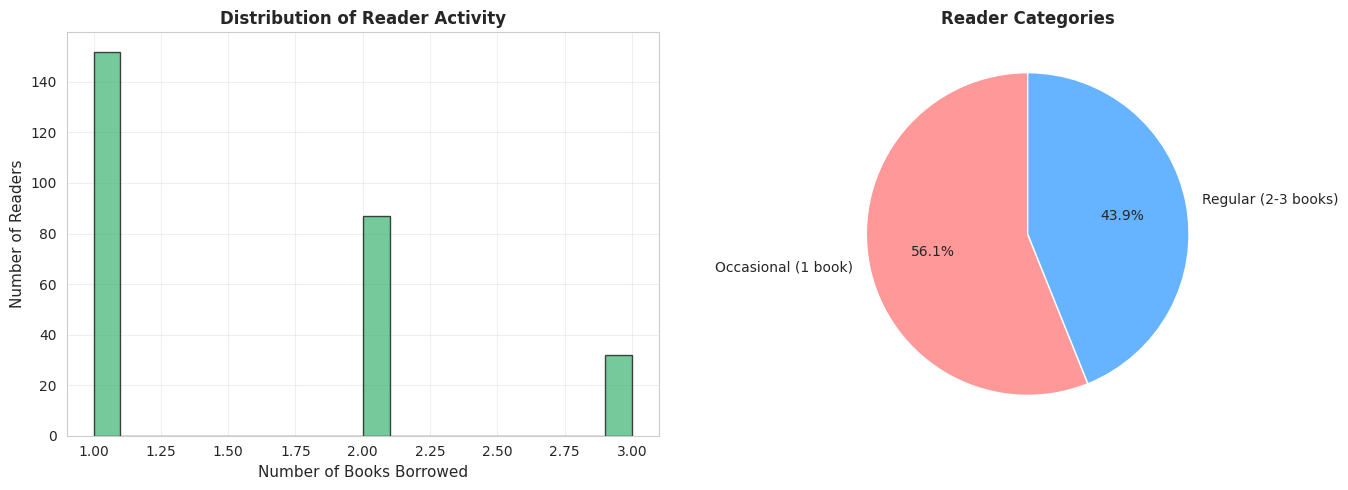


✓ Saved: eda_figures/04_reader_activity.png


In [ ]:
print("=" * 80)
print("READER BEHAVIOR ANALYSIS")
print("=" * 80)

# Calculate reader statistics
reader_borrowing_counts = df_borrowings['n° lecteur'].value_counts()

print(f"\nReader Activity Statistics:")
print(reader_borrowing_counts.describe())

# Categorize readers
def categorize_reader(count):
    if count == 1:
        return 'Occasional (1 book)'
    elif count <= 3:
        return 'Regular (2-3 books)'
    else:
        return 'Active (>3 books)'

reader_categories = reader_borrowing_counts.apply(categorize_reader)
category_counts = reader_categories.value_counts()

print(f"\nReader Categories:")
for category, count in category_counts.items():
    print(f"  {category}: {count} readers ({count/len(reader_categories)*100:.1f}%)")

# Visualize reader activity
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Distribution of borrowings per reader
ax1.hist(reader_borrowing_counts, bins=20, edgecolor='black', alpha=0.7, color='mediumseagreen')
ax1.set_xlabel('Number of Books Borrowed', fontsize=11)
ax1.set_ylabel('Number of Readers', fontsize=11)
ax1.set_title('Distribution of Reader Activity', fontsize=12, fontweight='bold')
ax1.grid(alpha=0.3)

# Reader categories pie chart
ax2.pie(category_counts.values, labels=category_counts.index, autopct='%1.1f%%',
        startangle=90, colors=['#ff9999', '#66b3ff', '#99ff99'])
ax2.set_title('Reader Categories', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('eda_figures/04_reader_activity.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Saved: eda_figures/04_reader_activity.png")

## 2.4 Temporal Trends

TEMPORAL TRENDS ANALYSIS


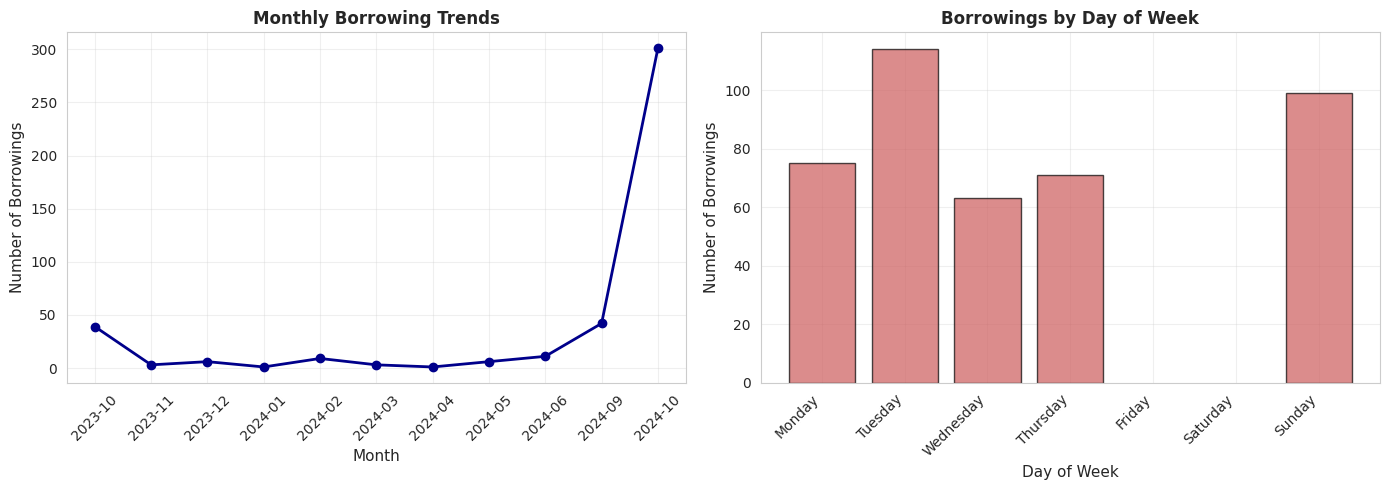


✓ Saved: eda_figures/05_temporal_trends.png

Most active month: 2024-10 (301 borrowings)
Least active month: 2024-01 (1 borrowings)


In [ ]:
print("=" * 80)
print("TEMPORAL TRENDS ANALYSIS")
print("=" * 80)

# Extract temporal features
df_borrowings['year_month'] = df_borrowings['date prêt'].dt.to_period('M')
df_borrowings['month_name'] = df_borrowings['date prêt'].dt.month_name()
df_borrowings['day_of_week'] = df_borrowings['date prêt'].dt.day_name()

# Monthly borrowing trends
monthly_borrowings = df_borrowings.groupby('year_month').size()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Time series plot
ax1.plot(monthly_borrowings.index.astype(str), monthly_borrowings.values,
         marker='o', linewidth=2, markersize=6, color='darkblue')
ax1.set_xlabel('Month', fontsize=11)
ax1.set_ylabel('Number of Borrowings', fontsize=11)
ax1.set_title('Monthly Borrowing Trends', fontsize=12, fontweight='bold')
ax1.grid(alpha=0.3)
ax1.tick_params(axis='x', rotation=45)

# Day of week distribution
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_counts = df_borrowings['day_of_week'].value_counts().reindex(day_order)
ax2.bar(range(len(day_counts)), day_counts.values,
        edgecolor='black', alpha=0.7, color='indianred')
ax2.set_xticks(range(len(day_counts)))
ax2.set_xticklabels(day_counts.index, rotation=45, ha='right')
ax2.set_xlabel('Day of Week', fontsize=11)
ax2.set_ylabel('Number of Borrowings', fontsize=11)
ax2.set_title('Borrowings by Day of Week', fontsize=12, fontweight='bold')
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('eda_figures/05_temporal_trends.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Saved: eda_figures/05_temporal_trends.png")

print(f"\nMost active month: {monthly_borrowings.idxmax()} ({monthly_borrowings.max()} borrowings)")
print(f"Least active month: {monthly_borrowings.idxmin()} ({monthly_borrowings.min()} borrowings)")

## 2.5 Catalogue Coverage Analysis

CATALOGUE COVERAGE ANALYSIS

Catalogue Statistics:
  Total books in catalogue: 582
  Books borrowed at least once: 133
  Books never borrowed: 449
  Circulation rate: 22.9%


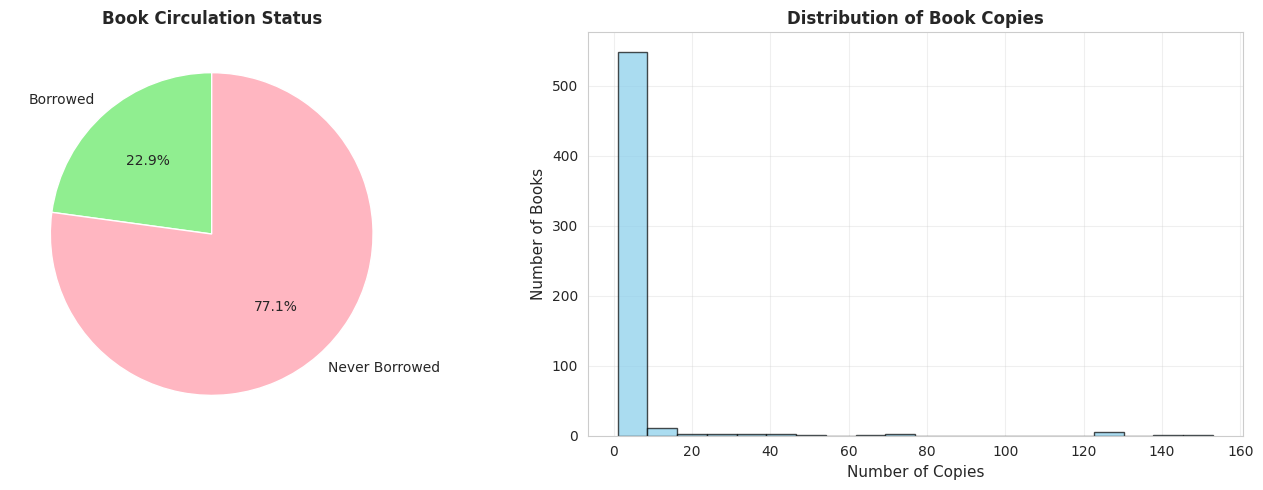


✓ Saved: eda_figures/06_catalogue_coverage.png


In [ ]:
print("=" * 80)
print("CATALOGUE COVERAGE ANALYSIS")
print("=" * 80)

# Merge with catalogue to get copy information
df_analysis = df_borrowings.merge(df_catalogue[['titre', 'nbr_exemplaires']],
                                  on='titre', how='left')

# Books in circulation vs available
books_in_borrowings = set(df_borrowings['titre'].unique())
books_in_catalogue = set(df_catalogue['titre'].unique())

borrowed_books = len(books_in_borrowings)
total_books = len(books_in_catalogue)
never_borrowed = total_books - borrowed_books

print(f"\nCatalogue Statistics:")
print(f"  Total books in catalogue: {total_books}")
print(f"  Books borrowed at least once: {borrowed_books}")
print(f"  Books never borrowed: {never_borrowed}")
print(f"  Circulation rate: {borrowed_books/total_books*100:.1f}%")

# Visualize
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Circulation status
labels = ['Borrowed', 'Never Borrowed']
sizes = [borrowed_books, never_borrowed]
colors = ['#90EE90', '#FFB6C1']
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors)
ax1.set_title('Book Circulation Status', fontsize=12, fontweight='bold')

# Distribution of copies
if 'nbr_exemplaires' in df_catalogue.columns:
    ax2.hist(df_catalogue['nbr_exemplaires'].dropna(), bins=20,
             edgecolor='black', alpha=0.7, color='skyblue')
    ax2.set_xlabel('Number of Copies', fontsize=11)
    ax2.set_ylabel('Number of Books', fontsize=11)
    ax2.set_title('Distribution of Book Copies', fontsize=12, fontweight='bold')
    ax2.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('eda_figures/06_catalogue_coverage.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Saved: eda_figures/06_catalogue_coverage.png")

---

# Phase 3: Feature Engineering

This phase creates structured features for data mining tasks:
1. **Book Features**: For clustering books by popularity and usage patterns
2. **Reader Features**: For clustering readers by activity and behavior
3. **Transaction Data**: For association rule mining to find co-borrowed books

## 3.1 Book Features for Clustering

In [ ]:
print("=" * 80)
print("CREATING BOOK FEATURES")
print("=" * 80)

# Calculate features
most_recent_date = df_borrowings['date prêt'].max()

book_features = df_borrowings.groupby('titre').agg({
    'numéro': 'count',  # Total borrowings
    'loan_duration_days': 'mean',  # Average loan duration
    'date prêt': lambda x: (most_recent_date - x.max()).days,  # Days since last borrow
    'n° lecteur': 'nunique'  # Unique readers
}).reset_index()

book_features.columns = ['titre', 'total_borrowings', 'avg_loan_duration',
                         'days_since_last_borrow', 'unique_readers']

# Merge with catalogue
book_features = book_features.merge(df_catalogue[['titre', 'nbr_exemplaires']],
                                    on='titre', how='left')
book_features['nbr_exemplaires'].fillna(1, inplace=True)

# Calculate derived features
book_features['borrowing_rate'] = book_features['total_borrowings'] / book_features['nbr_exemplaires']
book_features['reader_diversity'] = book_features['unique_readers'] / book_features['total_borrowings']

print(f"\nCreated features for {len(book_features)} books")
print(f"Feature columns: {list(book_features.columns)}")
print(f"\nFeature statistics:")
print(book_features[['total_borrowings', 'avg_loan_duration', 'unique_readers']].describe())

# Save
book_features.to_excel('book_features.xlsx', index=False)
print("\n✓ Saved to: book_features.xlsx")

CREATING BOOK FEATURES

Created features for 133 books
Feature columns: ['titre', 'total_borrowings', 'avg_loan_duration', 'days_since_last_borrow', 'unique_readers', 'nbr_exemplaires', 'borrowing_rate', 'reader_diversity']

Feature statistics:
       total_borrowings  avg_loan_duration  unique_readers
count        133.000000         133.000000      133.000000
mean           3.172932          18.684097        3.172932
std            8.230129          35.317928        8.230129
min            1.000000           7.000000        1.000000
25%            1.000000          14.000000        1.000000
50%            1.000000          15.000000        1.000000
75%            2.000000          15.333333        2.000000
max           57.000000         302.000000       57.000000

✓ Saved to: book_features.xlsx


## 3.2 Reader Features for Clustering

In [ ]:
print("=" * 80)
print("CREATING READER FEATURES")
print("=" * 80)

# Calculate features
reader_features = df_borrowings.groupby('n° lecteur').agg({
    'numéro': 'count',  # Total borrowings
    'loan_duration_days': 'mean',  # Average loan duration
    'date prêt': [lambda x: (most_recent_date - x.max()).days,  # Days since last activity
                  lambda x: (x.max() - x.min()).days],  # Activity span
    'titre': 'nunique'  # Unique books borrowed
}).reset_index()

reader_features.columns = ['n° lecteur', 'total_borrowings', 'avg_loan_duration',
                           'days_since_last_borrow', 'activity_span_days', 'unique_books']

# Calculate derived features
reader_features['book_diversity'] = reader_features['unique_books'] / reader_features['total_borrowings']
reader_features['reading_frequency'] = reader_features['total_borrowings'] / (reader_features['activity_span_days'] + 1)

print(f"\nCreated features for {len(reader_features)} readers")
print(f"Feature columns: {list(reader_features.columns)}")
print(f"\nFeature statistics:")
print(reader_features[['total_borrowings', 'avg_loan_duration', 'unique_books']].describe())

# Save
reader_features.to_excel('reader_features.xlsx', index=False)
print("\n✓ Saved to: reader_features.xlsx")

CREATING READER FEATURES

Created features for 271 readers
Feature columns: ['n° lecteur', 'total_borrowings', 'avg_loan_duration', 'days_since_last_borrow', 'activity_span_days', 'unique_books', 'book_diversity', 'reading_frequency']

Feature statistics:
       total_borrowings  avg_loan_duration  unique_books
count        271.000000         271.000000    271.000000
mean           1.557196          15.846863      1.557196
std            0.696189          17.949169      0.696189
min            1.000000           7.000000      1.000000
25%            1.000000          15.000000      1.000000
50%            1.000000          15.000000      1.000000
75%            2.000000          15.000000      2.000000
max            3.000000         302.000000      3.000000

✓ Saved to: reader_features.xlsx


## 3.3 Transaction Data for Association Rules

In [ ]:
print("=" * 80)
print("PREPARING TRANSACTION DATA FOR ASSOCIATION RULES")
print("=" * 80)

print("\nCreating transactions (reader-based)...")

# Create transactions: each transaction = all books borrowed by one reader
transactions = df_borrowings.groupby('n° lecteur')['titre'].apply(list).reset_index()
transactions.columns = ['reader_id', 'books']
transactions['transaction_size'] = transactions['books'].apply(len)

print(f"Total transactions (readers): {len(transactions)}")
print(f"\nTransaction size distribution:")
print(transactions['transaction_size'].describe())

# Filter out single-book transactions
transactions_filtered = transactions[transactions['transaction_size'] > 1].copy()
print(f"\nRemoved {len(transactions) - len(transactions_filtered)} single-book transactions")
print(f"Remaining transactions: {len(transactions_filtered)}")

# Statistics
unique_books_in_transactions = len(set([book for books in transactions_filtered['books'] for book in books]))
print(f"Unique books in transactions: {unique_books_in_transactions}")

# Save in multiple formats

# Format 1: List format (one row per transaction)
transactions_filtered.to_excel('transactions.xlsx', index=False)
print("\n✓ Saved to: transactions.xlsx")

# Format 2: Long format (one row per reader-book pair)
transactions_long = df_borrowings[['n° lecteur', 'titre']].copy()
transactions_long.columns = ['reader_id', 'book_title']

# Remove readers with only 1 book
reader_counts = transactions_long['reader_id'].value_counts()
valid_readers = reader_counts[reader_counts > 1].index
transactions_long = transactions_long[transactions_long['reader_id'].isin(valid_readers)]
transactions_long = transactions_long.drop_duplicates()

transactions_long.to_excel('transactions_long_format.xlsx', index=False)
print(f"✓ Saved to: transactions_long_format.xlsx ({len(transactions_long)} reader-book pairs)")

PREPARING TRANSACTION DATA FOR ASSOCIATION RULES

Creating transactions (reader-based)...
Total transactions (readers): 271

Transaction size distribution:
count    271.000000
mean       1.557196
std        0.696189
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max        3.000000
Name: transaction_size, dtype: float64

Removed 152 single-book transactions
Remaining transactions: 119
Unique books in transactions: 101

✓ Saved to: transactions.xlsx
✓ Saved to: transactions_long_format.xlsx (270 reader-book pairs)


---

# Final Summary

In [ ]:
print("\n" + "=" * 80)
print("PREPROCESSING COMPLETE - FINAL SUMMARY")
print("=" * 80)

print("\n📊 CLEANED DATASETS:")
print(f"  1. Borrowings: {df_borrowings.shape[0]} rows × {df_borrowings.shape[1]} columns")
print(f"  2. Catalogue: {df_catalogue.shape[0]} rows × {df_catalogue.shape[1]} columns")
print(f"  3. Inventory: {df_inventory.shape[0]} rows × {df_inventory.shape[1]} columns")

print("\n🎯 FEATURE DATASETS:")
print(f"  1. Book Features: {book_features.shape[0]} books × {book_features.shape[1]} features")
print(f"  2. Reader Features: {reader_features.shape[0]} readers × {reader_features.shape[1]} features")
print(f"  3. Transactions: {len(transactions_filtered)} transactions for association rules")

print("\n📈 VISUALIZATIONS:")
visualizations = [
    "01_loan_duration_distribution.png",
    "02_top_borrowed_books.png",
    "03_borrowing_frequency_distribution.png",
    "04_reader_activity.png",
    "05_temporal_trends.png",
    "06_catalogue_coverage.png"
]
for viz in visualizations:
    print(f"  ✓ eda_figures/{viz}")



PREPROCESSING COMPLETE - FINAL SUMMARY

📊 CLEANED DATASETS:
  1. Borrowings: 422 rows × 14 columns
  2. Catalogue: 582 rows × 5 columns
  3. Inventory: 4255 rows × 10 columns

🎯 FEATURE DATASETS:
  1. Book Features: 133 books × 8 features
  2. Reader Features: 271 readers × 8 features
  3. Transactions: 119 transactions for association rules

📈 VISUALIZATIONS:
  ✓ eda_figures/01_loan_duration_distribution.png
  ✓ eda_figures/02_top_borrowed_books.png
  ✓ eda_figures/03_borrowing_frequency_distribution.png
  ✓ eda_figures/04_reader_activity.png
  ✓ eda_figures/05_temporal_trends.png
  ✓ eda_figures/06_catalogue_coverage.png


---

## Appendix: Data Quality Checks

In [ ]:
print("DATA QUALITY REPORT")
print("=" * 80)

# Check for remaining issues
print("\n1. Borrowings Data:")
print(f"   Missing values: {df_borrowings.isnull().sum().sum()}")
print(f"   Duplicates: {df_borrowings.duplicated().sum()}")
print(f"   Date range valid: {df_borrowings['date prêt'].min() < df_borrowings['date retour'].max()}")

print("\n2. Book Features:")
print(f"   Missing values: {book_features.isnull().sum().sum()}")
print(f"   Negative values: {(book_features.select_dtypes(include=[np.number]) < 0).sum().sum()}")

print("\n3. Reader Features:")
print(f"   Missing values: {reader_features.isnull().sum().sum()}")
print(f"   Negative values: {(reader_features.select_dtypes(include=[np.number]) < 0).sum().sum()}")

DATA QUALITY REPORT

1. Borrowings Data:
   Missing values: 14
   Duplicates: 0
   Date range valid: True

2. Book Features:
   Missing values: 0
   Negative values: 0

3. Reader Features:
   Missing values: 0
   Negative values: 0
